# Mortality Rates in the Netherlands

> Last updated April 18, 2020

Source data:
- [Weekly mortatlity figures](https://opendata.cbs.nl/statline/portal.html?_la=nl&_catalog=CBS&tableId=70895ned&_theme=75)
- [Montly population figures](https://opendata.cbs.nl/statline/portal.html?_la=nl&_catalog=CBS&tableId=37943ned&_theme=62)
- [Daily COVID-19 deaths](https://www.rivm.nl/coronavirus-covid-19/grafieken)

Entry for mortality week 15 2020 added manually based on latest reports, which was not reflected in source data at time of writing ([see here](https://www.cbs.nl/en-gb/news/2020/16/mortality-in-second-week-of-april-estimated-at-5-000)).



In [1]:
import pandas as pd

In [2]:
deceased = pd.read_csv(
    'deceaseddata20200418.csv',
    sep=';',
    names=['id', 'sex', 'age', 'per', 'd'],
    skiprows=1,  # skip header
    dtype={'id':int,'sex':int,'age':int,'per':str,'d':int}
)

In [3]:
period_filters = (
    ~deceased.per.str.contains('X0') &  # remove incomplete first weeks of year
    ~deceased.per.str.contains('W101') &  # remove first weeks of year that could start in prev year
    ~deceased.per.str.contains('W152') &  # remove incomplete last week of year
    ~deceased.per.str.contains('W153') &  # remove incomplete last week of year (in 2011)
    ~deceased.per.str.contains('JJ')  # remove full year data contained in series
)

In [4]:
deceased = deceased[period_filters]

In [5]:
deceased['dt'] = pd.to_datetime(deceased.per + str(1), format='%GW1%V%u')

In [6]:
# confirm the only date format that remains is in W-format (weeks)
sum(deceased.per.str.contains('W')) == len(deceased.per.str.contains('W'))

True

In [7]:
# confirm that the inferred year matches the year in the period column
[int(year) for year in deceased.per.str[:4].tolist()] == pd.DatetimeIndex(deceased['dt']).year.tolist()

True

In [8]:
# keep only broad demographics (all genders and ages)
all_genders = deceased['sex']==1100
all_ages = deceased['age']==10000

demo_filters = all_genders & all_ages

In [9]:
deceased = deceased[demo_filters]

In [10]:
# cleanup columns
deceased = deceased.drop(['id','sex','age','per'], axis=1)

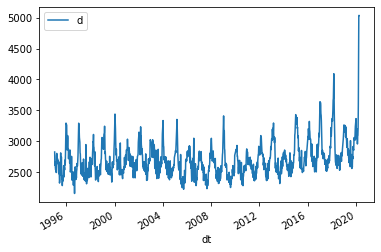

In [11]:
# quick plot show no spikes other than expected yearly seasonality
deceased.plot(x='dt')

In [12]:
pop = pd.read_csv(
    'populationdata20200418.csv',
    sep=';',
    usecols=[1, 9],
    names=['per', 'pop'],
    skiprows=1,  # skip header
    dtype={'per':str,'pop':int}
)

In [13]:
year_filters = (
    ~pop.per.str.contains('JJ') &
    ~pop.per.str.contains('KW')
)

In [14]:
pop = pop[year_filters]

In [15]:
pop['dt'] = pd.to_datetime(pop.per, format='%YMM%m')

In [16]:
pop = pop.drop('per', axis=1)

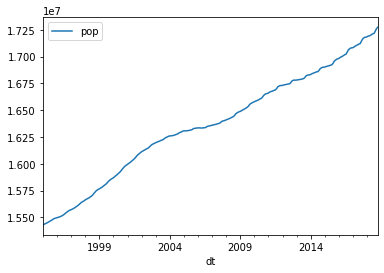

In [17]:
# quick plot to confirm data - population grew from roughly 15 to >17 million in time period
pop.plot(x='dt')

In [18]:
pop.head()

,pop,dt
0,15430178,1995-01-01
1,15436176,1995-02-01
2,15441920,1995-03-01
4,15446212,1995-04-01
5,15452370,1995-05-01


In [19]:
# merge on month grouper (population data is not available at weekly granularity)
merged = pd.merge(
    deceased.assign(grouper=deceased['dt'].dt.to_period('M')),
    pop.assign(grouper=pop['dt'].dt.to_period('M')),
    how='left',
    on='grouper'
)

In [20]:
# cleanup columns
merged = merged.drop(['grouper', 'dt_y'], axis=1).fillna(method='ffill')

In [21]:
# compute mortality rate (typically reported as deaths per 1000)
merged['mrate'] = merged['d'] / merged['pop'] * 1000

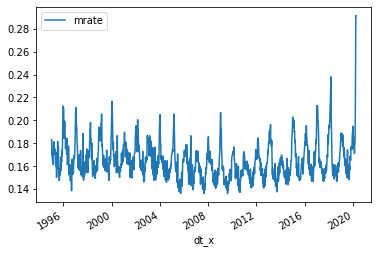

In [22]:
# quick plot to confirm data is properly scaled
merged.plot(x='dt_x', y='mrate')

In [23]:
# last three available weeks
merged[-3:]

,d,dt_x,pop,mrate
1261,4432,2020-03-23,17273746.0,0.256574
1262,5037,2020-03-30,17273746.0,0.291599
1263,5036,2020-04-06,17273746.0,0.291541


In [24]:
# create week and year columns for plot data
merged['week'] = merged.dt_x.dt.week
merged['year'] = merged.dt_x.dt.year

In [208]:
plotdata = merged.pivot(index='week',columns='year',values='mrate')

In [209]:
# convert to string headers as integers break pandas/bokeh
plotdata.columns = [str(header) for header in plotdata.columns.tolist()]

In [210]:
plotdata['mn'] = plotdata.iloc[:,:-1].mean(axis=1)  # calculate means for 1995-2019

In [211]:
plotdata['s'] = plotdata.iloc[:,:-2].std(axis=1)  # calculate standard deviations for 1995-2019

In [212]:
plotdata['upper'] = plotdata['mn'] + 2 * plotdata['s']  # upper 2-sigma CI level

In [213]:
plotdata['lower'] = plotdata['mn'] - 2 * plotdata['s']  # lower 2-sigma CI level

In [214]:
plotdata = plotdata.drop('s', axis=1)  # remove standard deviation from plotdata

In [215]:
# sanity check
plotdata.head(3)

,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,...,2014,2015,2016,2017,2018,2019,2020,mn,upper,lower
week,,,,,,,,,,,,,,,,,,,,,
2,0.182953,0.210162,0.211274,0.163309,0.190588,0.216636,0.178304,0.195185,0.184409,0.204989,...,0.167460,0.202866,0.181056,0.212892,0.195458,0.188841,0.194746,0.186908,0.219063,0.154754
3,0.169084,0.191643,0.208641,0.154371,0.185070,0.208381,0.181742,0.188172,0.184038,0.187892,...,0.162767,0.199790,0.180291,0.204112,0.195749,0.182358,0.182416,0.182119,0.213666,0.150573
4,0.172649,0.184222,0.204531,0.161521,0.181772,0.201828,0.189495,0.191089,0.182927,0.179650,...,0.160984,0.198370,0.188475,0.212248,0.193305,0.183979,0.175990,0.181444,0.210987,0.151902


In [216]:
cd = pd.read_csv(
    'coronadeaths20200418.csv',
    sep=';',
    names=['date', 'new', 'known'],
    skiprows=1,
    dtype={'date':str,'new':int,'known':int}
)

In [217]:
cd.date = cd.date + ' 2020'

In [ ]:
for i in range(len(cd.date.tolist())):
    if cd.date[i][1] == ' ':
        cd.date[i] = '0' + str(cd.date[i])
    cd.date[i] = str(cd.date[i]).replace('feb', 'February')
    cd.date[i] = str(cd.date[i]).replace('mrt', 'March')
    cd.date[i] = str(cd.date[i]).replace('apr', 'April')

In [219]:
cd.index = pd.to_datetime(cd.date, format='%d %B %Y')

In [220]:
cdw = cd.resample('W').sum()

In [221]:
cdw['total'] = cdw.new + cdw.known

In [222]:
cdw

,new,known,total
date,,,
2020-03-01,0,0,0
2020-03-08,0,4,4
2020-03-15,0,37,37
2020-03-22,0,285,285
2020-03-29,2,766,768
2020-04-05,19,1077,1096
2020-04-12,14,907,921
2020-04-19,110,368,478


In [223]:
cdw.index = [i.isocalendar()[1] for i in cdw.index]
cdw.index.name = 'week'

In [224]:
cdw

,new,known,total
week,,,
9,0,0,0
10,0,4,4
11,0,37,37
12,0,285,285
13,2,766,768
14,19,1077,1096
15,14,907,921
16,110,368,478


In [230]:
for i in cdw.index[1:7]:
    plotdata.loc[i, 'coronadeaths'] = (cdw.loc[i, 'total'] / merged.loc[1262, 'pop'] * 1000) + plotdata.loc[i, 'mn']

In [231]:
plotdata.loc[15]

1995            0.171239
1996            0.170358
1997            0.157214
1998            0.185568
1999            0.160435
2000            0.169021
2001            0.171788
2002            0.178175
2003            0.168410
2004            0.157401
2005            0.160342
2006            0.167936
2007            0.159767
2008            0.160930
2009            0.158783
2010            0.155659
2011            0.159022
2012            0.164698
2013            0.182238
2014            0.153833
2015            0.170754
2016            0.162731
2017            0.164280
2018            0.166284
2019            0.167885
2020            0.291541
mn              0.165790
upper           0.181958
lower           0.149623
coronadeaths    0.219108
Name: 15, dtype: float64

In [232]:
plotdata.head(25)

,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,...,2015,2016,2017,2018,2019,2020,mn,upper,lower,coronadeaths
week,,,,,,,,,,,,,,,,,,,,,
2,0.182953,0.210162,0.211274,0.163309,0.190588,0.216636,0.178304,0.195185,0.184409,0.204989,...,0.202866,0.181056,0.212892,0.195458,0.188841,0.194746,0.186908,0.219063,0.154754,NaN
3,0.169084,0.191643,0.208641,0.154371,0.185070,0.208381,0.181742,0.188172,0.184038,0.187892,...,0.199790,0.180291,0.204112,0.195749,0.182358,0.182416,0.182119,0.213666,0.150573,NaN
4,0.172649,0.184222,0.204531,0.161521,0.181772,0.201828,0.189495,0.191089,0.182927,0.179650,...,0.198370,0.188475,0.212248,0.193305,0.183979,0.175990,0.181444,0.210987,0.151902,NaN
5,0.167010,0.193062,0.196568,0.171800,0.188420,0.186957,0.183055,0.182338,0.174160,0.178789,...,0.196536,0.182615,0.209204,0.198018,0.181952,0.182763,0.180886,0.205981,0.155791,NaN
6,0.164289,0.199280,0.193358,0.166877,0.196852,0.178530,0.178770,0.177369,0.169419,0.169175,...,0.193526,0.178672,0.201621,0.204339,0.184384,0.184558,0.180133,0.206214,0.154052,NaN
7,0.165261,0.196506,0.191303,0.171982,0.197993,0.174626,0.172521,0.172344,0.168863,0.165547,...,0.195833,0.178143,0.199924,0.212889,0.188263,0.184963,0.179365,0.207138,0.151592,NaN
8,0.162605,0.186248,0.180197,0.173514,0.198691,0.180671,0.167772,0.183449,0.180405,0.168867,...,0.199973,0.195327,0.194717,0.214692,0.186526,0.170953,0.181063,0.208613,0.153513,NaN
9,0.161309,0.185667,0.179235,0.167643,0.205385,0.168328,0.171771,0.200447,0.186453,0.167392,...,0.189682,0.187441,0.184420,0.229001,0.177495,0.178711,0.180403,0.213667,0.147140,NaN
10,0.179382,0.175046,0.169416,0.179383,0.195055,0.169298,0.180870,0.186987,0.184560,0.167253,...,0.190539,0.185376,0.178609,0.237994,0.183573,0.179000,0.180481,0.212845,0.148116,0.180712


In [233]:
from bokeh.plotting import figure, output_file, save
from bokeh.models import Span, Label, Title

In [ ]:
output_file('mortality.html', title='Mortality Rate in the Netherlands')

cols=len(plotdata.columns)

fig = figure(
    tools='pan,wheel_zoom,box_zoom,save,reset',
    x_axis_label='Week Number',
    x_minor_ticks=10,
    x_range=[1,52],
    y_axis_label='Mortality Rate (per 1000 citizens)',
    plot_width=1000,
    plot_height=600,
    toolbar_location='above'
)

fig.title.text = 'Weekly Mortality Rate in the Netherlands 1995-2020'
fig.title.align = 'center'
fig.title.text_font_size = '25px'

fig.add_layout(
    Title(
        text='Source: Statistics Netherlands (2020), RIVM (2020). Preliminary data for 2019 and 2020.', 
        align='left',
        text_font_size='12px'
    ),
    'below'
)


fig.add_layout(Span(
    location=9,
    dimension='height',
    line_color='red',
    line_dash='dashed',
    line_width=1.5,
    line_alpha=0.5
))

fig.add_layout(Label(
    x=1.5,
    y=0.261,
    text='First COVID-19 death',
    render_mode='css',
    text_font_size='14px'
))

for i in range(cols-6):  # add all historic years
    fig.line(
        x=plotdata.index,
        y=plotdata.iloc[:,i],
        line_color='grey',
        line_alpha=0.15,
        line_width=1
    )

fig.line(
    x=plotdata.index,
    y=plotdata['2019'],
    line_color='grey',
    line_alpha=0.15,
    line_width=1
)


fig.line(
    x=plotdata.index,
    y=plotdata.mn,
    line_color='black',
    line_alpha=0.5,
    line_width=1.5,
    legend_label='Average (1995-2019)'
)

fig.line(
    x=plotdata.index,
    y=plotdata.upper,
    line_color='black',
    line_alpha=0.5,
    line_width=1.5,
    line_dash='dotted',
    legend_label='95% CI (1995-2019)'
)

fig.line(
    x=plotdata.index,
    y=plotdata.lower,
    line_color='black',
    line_alpha=0.5,
    line_width=1.5,
    line_dash='dotted'
)


fig.line(
    x=plotdata.index,
    y=plotdata['2018'],
    line_color='blue',
    line_alpha=1,
    line_width=1.5,
    legend_label='2018 (influenza epidemic)'
)

fig.varea(
    x=plotdata.index[8:],
    y1=plotdata['coronadeaths'][8:],
    y2=plotdata['2020'][8:],
    fill_alpha=0.15,
    fill_color='grey'
)

fig.line(
    x=plotdata.index,
    y=plotdata['2020'],
    line_color='red',
    line_alpha=1,
    line_width=3,
    legend_label='2020 (COVID-19 outbreak)'
)

fig.line(
    x=plotdata.index,
    y=plotdata['coronadeaths'],
    line_color='orange',
    line_alpha=1,
    line_width=3,
    line_dash='dashed',
    legend_label='Avg + reported COVID-19 deaths (RIVM)'
)

fig.add_layout(Label(
    x=16,
    y=0.26,
    text='Potential under-reported cases',
    render_mode='css',
    text_font_size='14px'
))

save(fig)